In [1]:
import csv
import numpy as np
import keras
from keras import losses, regularizers
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.optimizers import Adam, SGD
import h5py
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn import svm, metrics
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import seaborn as sns
from helpers import normalize_data

Using TensorFlow backend.


In [2]:
### Load the data ###

# Data after normalization with Metabo Analyst 4.0
with open("C:/Users/wolfgang.schwab/Desktop/Lokal/RocheDataChallenge/MetaboAnalyst_merged_data_comma.csv") as f:
  dataset_log2 = f.readlines()
# Raw data
with open("C:/Users/wolfgang.schwab/Desktop/Lokal/RocheDataChallenge/Expressiondata.txt") as f:
  dataset_unnormed = f.readlines()

In [5]:
### Data preprocessing ###

labels = np.asarray([1 if x =='adenocarcinoma' else 0 for x in dataset_log2[1].split(';')[1:]], dtype = int)

complete_data_split = []
for line in dataset_log2:
    complete_data_split.append(line.replace(",",".").split(';')[1:])  
    

data_log2 = np.asarray(complete_data_split[2:][1:], dtype = float)
data_normed = normalize_data(dataset_unnormed, normalization = "MinMax")

print(data_normed.shape)
print(data_log2.shape)

data_transp = np.transpose(data_log2)
data_train, data_val, label_train, label_val = train_test_split(data_transp, labels, test_size=0.2)

(23444, 594)
(23444, 594)


In [16]:
### Selection of biomarkers used for classification ###

#biomarker_ids = [0, 1]
#biomarker_ids = [1220, 7193] ## TP63 and NKX2-1
biomarker_ids = [1527,3260] ## lowest pval score
biomarkers = [x - 1 for x in biomarker_ids]
data_train_selected = data_train[:,biomarkers]
data_val_selected = data_val[:,biomarkers]

In [17]:
### Building the neural network ###

model = Sequential()
model.add(Dense(5, activation='relu',input_shape = (len(biomarkers),),kernel_initializer='random_normal'))
model.add(Dropout(0.1))
model.add(Dense(5, activation='relu',input_shape = (len(biomarkers),),kernel_initializer='random_normal'))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid',kernel_initializer='random_normal'))

In [18]:
### Training the neural network ### 
adam_opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
rms_opt = keras.optimizers.RMSprop(lr=0.001, rho=0.9)

model.compile(optimizer =adam_opt,loss='binary_crossentropy', metrics =['accuracy'])

checkpointer = ModelCheckpoint(filepath='RDC.hdf5', 
                               verbose=0, save_best_only=True)

hist = model.fit(data_train_selected,label_train, batch_size=32, epochs=100, validation_split=0.1, callbacks=[checkpointer], verbose = 0)       

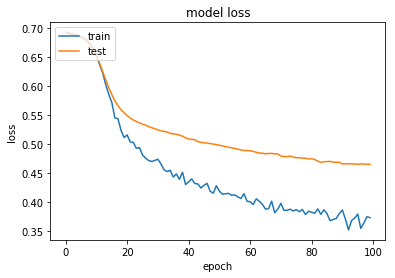

In [19]:
### Display the loss ###

model.load_weights('RDC.hdf5')

plt.figure()
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [20]:
### Evaluation of neural network accuracy ###

result = model.evaluate(data_val_selected, label_val)
print("Accuracy of model is: " + str(100 * result[1]) + "%")

119/119 [==============================] - 0s 109us/step
Accuracy of model is: 91.59663905616567%


In [28]:
### Create a svm Classifier ###

clf = svm.SVC(kernel='rbf', gamma = 'auto') # Linear Kernel
clf.fit(data_train_selected, label_train)
label_pred = clf.predict(data_val_selected)
print("Accuracy:",metrics.accuracy_score(label_val, label_pred))
X = data_val_selected
y = label_val

Accuracy: 0.907563025210084


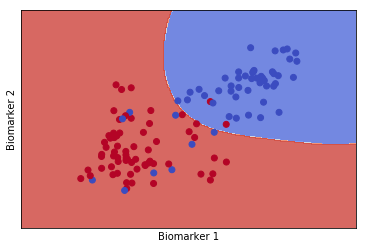

In [22]:
### Display SVM classification result ###

h = .02
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)

# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm)
plt.xlabel('Biomarker 1')
plt.ylabel('Biomarker 2')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())
plt.show()

In [23]:
### Display confusion matrix for SVM ###

cm = np.array(confusion_matrix(label_val,label_pred,[1,0]))
confusion = pd.DataFrame(cm, index = ['is_AC','is_SC'], columns = ['predicted_AC','predicted_SC'])
confusion

,predicted_AC,predicted_SC
is_AC,63,2
is_SC,9,45


In [27]:
### Cross validation for SVM ###

X = data_transp[:,biomarkers]
scores = cross_val_score(clf, data_transp[:,biomarkers], labels, cv=5)
np.mean(scores)

0.8971779898400039

In [25]:
### Cross validation for NN ###


kfold = StratifiedKFold(n_splits=5, shuffle=True)
cvscores = []
print(data_train_selected.shape)
for train, test in kfold.split(X, labels):
  # create model
    model = Sequential()
    model.add(Dense(5, activation='relu',input_shape = (len(biomarkers),),kernel_initializer='random_normal'))
    model.add(Dropout(0.1))
    model.add(Dense(5, activation='relu',input_shape = (len(biomarkers),),kernel_initializer='random_normal'))
    model.add(Dropout(0.1))
    model.add(Dense(1, activation='sigmoid',kernel_initializer='random_normal'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    # Fit the model
    model.fit(X[train],labels[train], batch_size=32, epochs=100, validation_split=0.1, callbacks=[checkpointer], verbose = 0) 
    # evaluate the model
    scores = model.evaluate(X[test],labels[test], verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

(475, 2)
acc: 88.33%
acc: 88.24%
acc: 85.71%
acc: 93.22%
acc: 92.37%
89.58% (+/- 2.81%)
